# bloch_schrödinger - A ready-made solver for 2D time-indepedant linear problems

This package provides a user-friendly environment designed to solve the time-independant Bloch-Schrödinger equation:

$$\left[-\frac{\hbar^2}{2 m_c} \Delta + V(\textbf{r}) \right] e^{i \textbf{k} \cdot \textbf{r}} u(\textbf{r}) = \delta E e^{i \textbf{k} \cdot \textbf{r}} u(\textbf{r})$$

It contains three main classes, `Potential`, `FDSolver` and `PWSolver`, as well as interactive plotting functions made to be used in notebooks environments. In this tutorial, we will explore the `Potential` class, made to facilitate the construction of parameter-dependant potentials and the `FDSolver` class, who handles the Hamiltonian diagonalization using a finite-difference method. The `PWSolver` class, who implements a plane-wave expansion method for smooth potentials, is introduced in its [dedicated tutorial](docs\PlaneWaveSolver.ipynb).

## Drawing energy landscapes - The Potential class

The first of the two class of this project is the 'Potential' class. It allows the user to draw arbitrary potentials with a simple synthax. The 'potential' submodule also contains common predefined potential shapes, such as the honeycomb lattice unit cell.

In [1]:
from bloch_schrodinger.potential import Potential
import matplotlib.pyplot as plt

a1 = [2,-2]
a2 = [2, 2]

foo = Potential(
    unitvecs=[a1, a2],
    resolution=(100, 100),
    v0 = 100
)

print(foo)

Potential: 
 a1 = [ 2 -2], a2 = [2 2] 
 dimensions: {'a1': 100, 'a2': 100}


We have instanced a new empty potential object. Right now, it is only two dimensional, meaning that a single potential landscape is stored. This potential landscape is defined in a box with sides $\vec{a_1}$ and $\vec{a_2}$ and centered on $(0,0)$, stored in the attribute foo.V, a xarray.DataArray object. The potential is sampled along the directions defined by a1 and a2. We can plot this potential as a function of x and y, using the 'plot' class method.

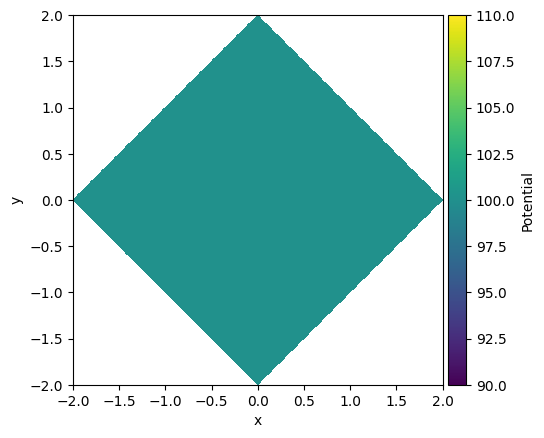

In [2]:
foo.plot() # The plot method generates matplotlib Figure and Axes objects
plt.show()

Now, let's add a circular well to this potential.

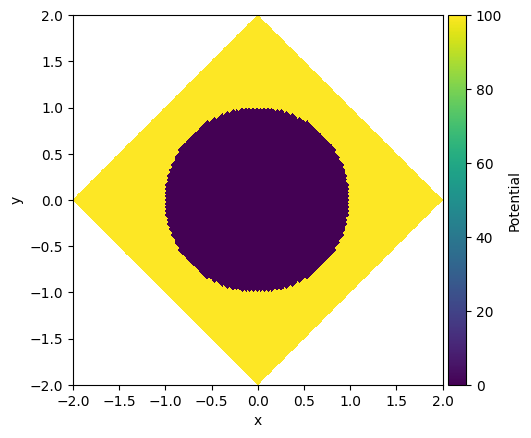

In [3]:
foo.circle(
    center = (0,0), # The center of the circle
    radius=1, # Its radius
    value = 0, # The value of the potential in the circle
    method='set' # The method, can either set the potential inside the circle, or add it to the value already there
)

foo.plot()
plt.show()

The 'circle' class method allowed us to specify the value of the potential inside the circle, but we can go further than that, introducing 'potential parameters':

Potential: 
 a1 = [ 2 -2], a2 = [2 2] 
 dimensions: {'a1': 100, 'a2': 100, 'r': 50}


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x', ylabel='y'>)

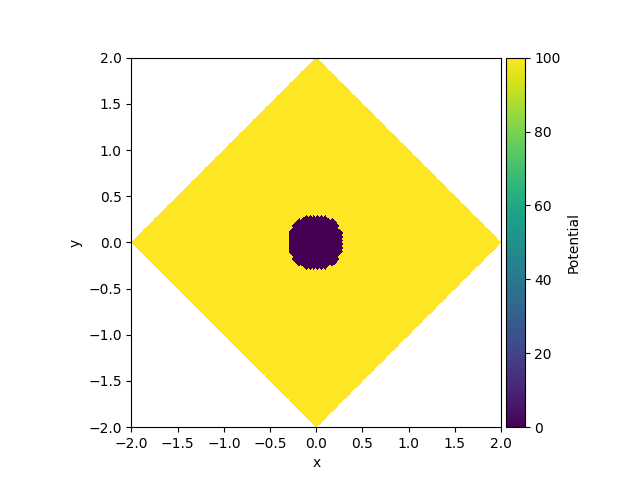

In [ ]:
# Magic command to activate interactivity
%matplotlib widget 

from bloch_schrodinger.potential import create_parameter
import numpy as np
import matplotlib.pyplot as plt

radius = create_parameter(
    name='r',
    data=np.linspace(0.3, 1.3),
)

foo = Potential(
    unitvecs=[a1, a2],
    resolution=(100, 100),
    v0 = 100
)

foo.circle(
    center = (0,0),
    radius=radius,
)

print(foo)
foo.plot()
plt.show()

Here we can see two things. First, a new dimension 'r' has appeared in our potential, second, we now have a slider in our plot. What we done is tell our Potential object to create multiple potential lanscape, each with a circle radius given by the values in the 'radius' parameter. This parameter object is just a xr.DataArray object, basically a numpy array with fancy additional methods (see [xarray documentation](https://docs.xarray.dev/en/stable/index.html) for more informations).

Almost all arguments of the drawing functions allow for parameters to be passed, here, both entries of 'center', radius, as well as 'value' accept parameters. Two parameters are also included directly in the Potential object, which are 'x' and 'y'. Those should only be used to fix the 'value' argument. Thanks to the power of DataArrays, some fancy parameters spaces can be created easily:

Potential: 
 a1 = [ 2 -2], a2 = [2 2] 
 dimensions: {'a1': 100, 'a2': 100, 'x center': 50}


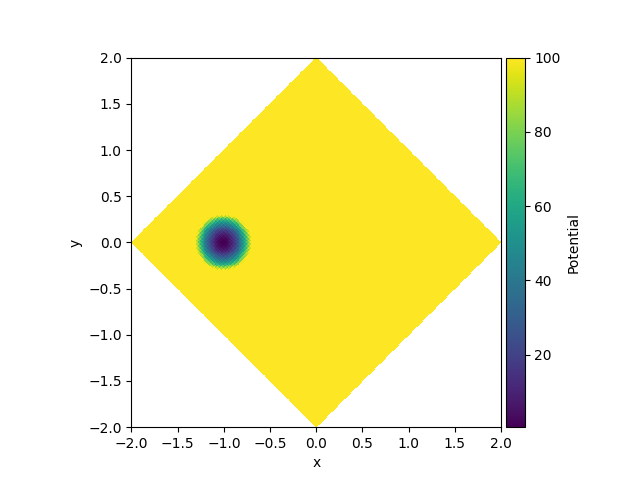

In [5]:
foo = Potential(
    unitvecs=[a1, a2],
    resolution=(100, 100),
    v0 = 100
)


x_center = create_parameter('x center', np.linspace(-1,1,50))

foo.circle(
    center =(x_center, 0),
    radius = 1.3-abs(x_center),
    value = ((foo.x - x_center)**2 + foo.y**2)*100/(1.3-abs(x_center))**2
)
print(foo)
foo.plot()
plt.show()

Let's get back to a simple parameter space, then move on to the *piece de resistance*, the 'FDSolver' class.

In [6]:
foo = Potential(
    unitvecs=[a1, a2],
    resolution=(100, 100),
    v0 = 100
)

radius = create_parameter(
    name='r',
    data=np.linspace(0.3, 1.3, 21),
)

foo.circle(
    center = (0,0),
    radius=radius,
)

## Diagonalizing the Hamiltonian - The 'FDSolver' class

Now that we have defined a potential, we only have to solve the Schrödinger equation:

$$\left[-\frac{\hbar^2}{2 m_c} \Delta + V(\textbf{r}) \right] e^{i \textbf{k} \cdot \textbf{r}} u(\textbf{r}) = \delta E e^{i \textbf{k} \cdot \textbf{r}} u(\textbf{r}) $$

As you might have noticed, the second term of this equation shows the eigenfunction as $u(\textbf{r}) e^{i \textbf{k} \cdot \textbf{r}}$ and not simply $\psi(\textbf{r})$. This is because this package is meant to solve the *Bloch-Schrödinger* equation, who states that all the eigenfunctions can be indexed by the two quantum numbers $n$ and $\textbf{k}$ in a periodic system, with n the band index, $\textbf{k}$ the crystal-momentum and the eigenfunctions written as $\psi_{\textbf{k}}^n (\textbf{r}) = u_{\textbf{k}}^n(\textbf{r}) e^{i \textbf{k} \cdot \textbf{r}}$. Of course the equation we solve reduces to a Schrödinger equation with periodic boundary conditions when $\textbf{k} = 0$.

The beauty of this shape for the eigenfunctions is that we can apply the laplacian operator to the exponential part, recovering the final equation for $u_{\textbf{k}}^n(\textbf{r})$:

$$\left[-\frac{\hbar^2}{2 m_c} \Delta + 2i \frac{\hbar^2}{2 m_c} \textbf{k} \cdot \nabla - \frac{\hbar^2 k^2}{2 m_c} + V(\textbf{r}) \right] u(\textbf{r}) = \delta E u_{\textbf{k}}^n(\textbf{r})$$



In this first part, we are going to ignore $\textbf{k}$, by setting it to 0. Now, let's create a FDSolver object.

In [7]:
from bloch_schrodinger.fdsolver import FDSolver

bar = FDSolver(
    potentials=foo,
    alphas = 0.1,
)

print(bar)

Solver object 
 size (10000, 10000), with 1 field(s) 
 dimensions: {'r': 21}


Here, we have created a FDSolver object. The class constructor takes as arguments a Potential object and an alpha term, that can be either a float or a parameter array. Here, alpha is defined as $\alpha = \frac{\hbar}{2 m}$ and contains the energy/momentum scale of the problem, it is advised to keep it close to 1.

The attentive reader might have noticed the use of the plural for the arguments, this is because lists of potentials and alphas can be given, to solve coupled equations with multiple field. The way to do it is shown in other notebooks.

What the Solver class does is to encapsulate the creation of a discretized Hamiltonian matrix. This very large sparse matrix, of size $(N \times M \times n_{fields}, N \times M \times n_{fields})$ for potentials of resolution $(N,M)$ is then solved using the scipy.sparse.linalg.eigsh function. This function solve the eigenvalue problem only for a few eigenvalues, which allows it to be very fast. The eigenvectors are computed in a flattened shape $(N \times M \times n_{fields},)$ and are then reshaped automatically to match the dimensions of the potential mesh. 

The gradient and laplacian operators are discretized using large, symmetric shells of neighboring points. They are automatically chosen to suppress second-order anisotropy and are stable even for very slanted grids.

This process is called with the 'solve' class method, that solve independantly the equation for every point in parameter space, before returning the eigenvalues and eigenvectors as DataArrays.

In [8]:
eigva, eigve = bar.solve(n_eigva=10)

Performing 21 diagonalizations...


100%|██████████| 21/21 [00:21<00:00,  1.00s/it]


storing the results


100%|██████████| 21/21 [00:00<00:00, 550.18it/s]


As one can see, the solver is not that fast. The time to solve for a single parameter point depends on a lot of parameters, and can range from 0.1s to 10s for very large grids. It is advised to keep the potential resolution as small as acceptable, and to not make the parameter space too large. This solver is built for ease of use more than performance, however, it can be parallelized by setting the `parallel` argument to `True`. The parallelization is handled by joblib and is not used by default because of the large overhead.


## Plotting the results

Right now, two main interactive plotting functions exists. One for eigenvector visualization, one for eigenvalue visualization. Of course, since the eigenvalues and eigenvectors returned are numpy arrays wrapped inside a xarray DataArray, it is very easy to create your own plotting functions, interactive or not.

The function 'plot_eigenvector' allows one to plot interactively the 2D profiles of the mode with overlapping potential levels. One can plot multiple profiles at the same time and explore the parameter space using the sliders.

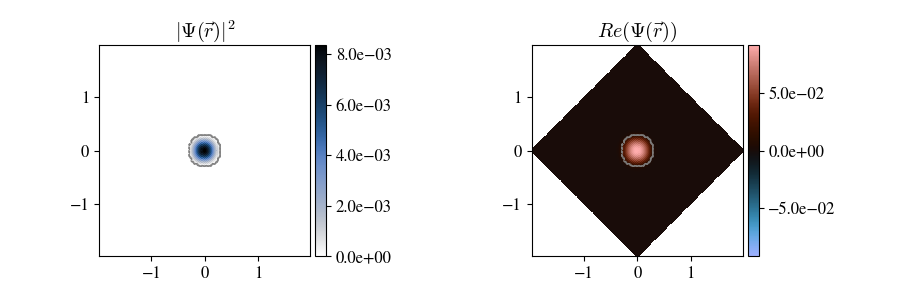

In [ ]:
from bloch_schrodinger.plotting import plot_eigenvector, plot_cuts

fig, axs = plot_eigenvector(
    plots = [[abs(eigve)**2, eigve.real]],
    potentials = [[foo, foo]],
    templates = [['amplitude', 'real']],
)
axs[0][0].set_title(r'$|\Psi(\vec{r})|^2$') # The axs are contained in a nested list of the same shape as plots or potentials
axs[0][1].set_title(r'$Re(\Psi(\vec{r}))$')

plt.show()

The 'plot_cuts' function allows to interactively plot the energy levels as a function of a specified dimension. Here, we can for example clearly see the $1/r^2$ dependance of the energy levels:

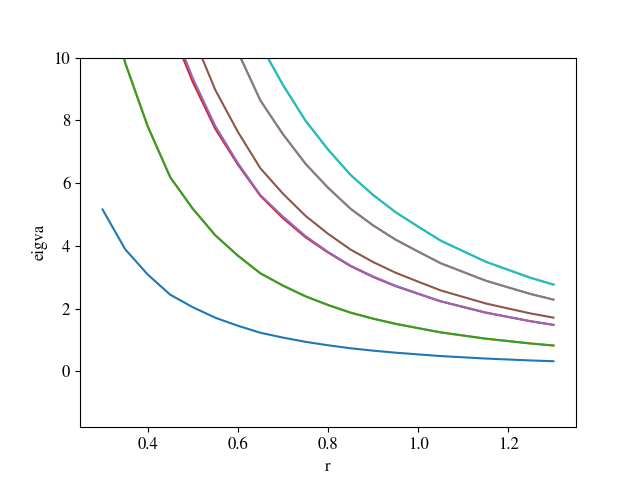

In [14]:
plot_cuts(eigva, 'r', ymax= 10)
plt.show()

## Computing band structures

The main feature of this package is the possibility to easily solve the equation for multiple values of $\textbf{k}$. Let's create a simple lattice unit cell and see how it goes.

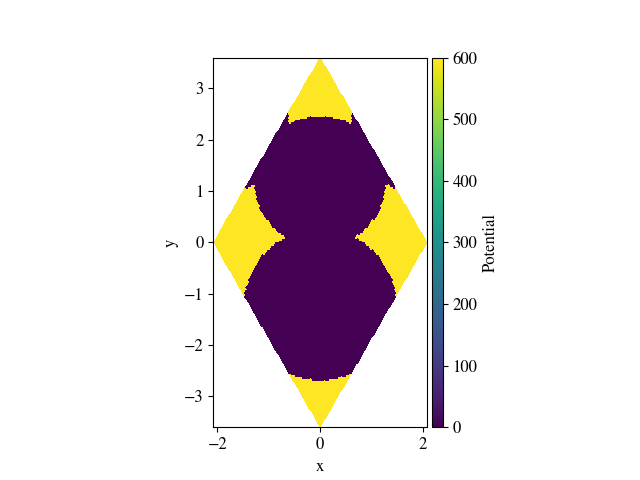

In [15]:
a = 2.4 # Inter pillar distance
dr = create_parameter('dr', np.linspace(-0.1,0.1,3))
rA = 2.75/2 + dr
rB = 2.75/2 - dr

a1 = np.array([-3**0.5/2 * a, 3/2 * a]) # 1st lattice vector
a2 = np.array([ 3**0.5/2 * a, 3/2 * a]) # 2nd lattice vector

Honey = Potential([a1,a2], (100,100), v0 = 600)

posA = np.array([0,a/2])
posB = np.array([0,-a/2])
ucs = [(0,0),(0,1),(0,-1),(-1,0),(1,0)]
for uc in ucs:
    centerA = posA + a1*uc[0] + a2*uc[1]
    centerB = posB + a1*uc[0] + a2*uc[1]
    Honey.circle(centerA, rA, value = 0)
    Honey.circle(centerB, rB, value = 0)
    
Honey.plot()
plt.show()

In [16]:
example = FDSolver(
    potentials=Honey,
    alphas = 1
)

# Some important reciprocal vectors
K = np.array([4*np.pi/3**1.5/a, 0])
a1s = np.array([3**0.5, -1])*2*np.pi/3/a
a2s = np.array([3**0.5,  1])*2*np.pi/3/a

#Let's creat a grid going through the high-symmetry points
M_to_Kp = np.linspace(-a1s[0],-K[0],5, endpoint=False)
Kp_to_K = np.linspace(-K[0], K[0], 30, endpoint=False)
K_to_M = np.linspace(K[0], a1s[0], 5)
kxs = np.concatenate([M_to_Kp,Kp_to_K,K_to_M])

example.create_reciprocal_grid(
    kx = kxs,
    ky = 0,
)

eigva, eigve = example.solve(
    n_eigva=6,
    parallel=True
)

Performing 120 diagonalizations...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 106 out of 120 | elapsed:   44.2s remaining:    5.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   46.9s finished


storing the results


100%|██████████| 120/120 [00:00<00:00, 682.82it/s]


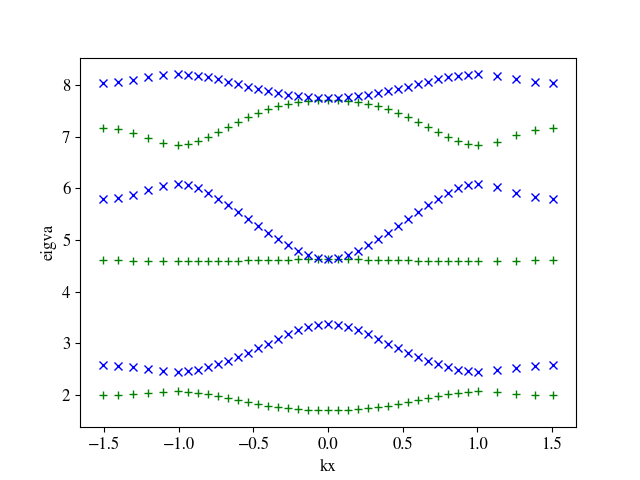

In [17]:
# plot band can accept list of keywords arguments to style each band independantly
lineskws = [
    dict(color = 'green', marker = '+', linestyle = 'none'),
    dict(color = 'blue', marker = 'x', linestyle = 'none')
]

plot_cuts(eigva, 'kx', linekws=lineskws)
plt.show()

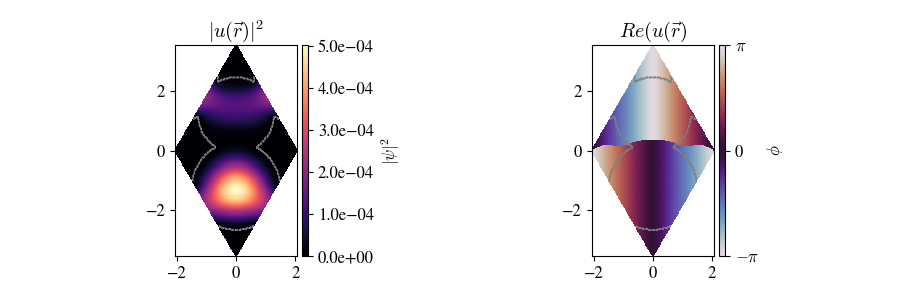

In [21]:
from xarray.ufuncs import angle # Importing the xarray version of np.angle to plot the phase

# The plot eigenvector function takes for templates either strings ('amplitude', 'phase', 'real' and a few others), 
# or dictionnaries for more user control of the plotting parameters.  One can also get the predefined dictionnaries directly, 
# then modify them to be used in the function.

from bloch_schrodinger.plotting import cmesh_tmpl

amplitude_template = cmesh_tmpl('amplitude')

amplitude_template['fkwargs']['cmap'] = 'magma'
amplitude_template['colorbar']['kwargs']['label'] = r'$|\psi|^2$'

fig, axs = plot_eigenvector(
    plots = [[abs(eigve)**2, angle(eigve)]],
    potentials = [[Honey, Honey]],
    templates = [[amplitude_template, 'phase']],
)
axs[0][0].set_title(r'$|u(\vec{r})|^2$')
axs[0][1].set_title(r'$Re(u(\vec{r})$')

plt.show()